# Определение стоимости автомобилей

Построим модель регрессии для определения рыночной стоимости автомобиля.

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Модель необходимо построить на основе исторических данных.


В нашем распоряжении исторические данные:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- технические характеристики и комплектация автомобиля:
    - Model — модель автомобиля
    - Brand — марка автомобиля
    - VehicleType — тип автомобильного кузова
    - Gearbox — тип коробки передач
    - FuelType — тип топлива
    - Power — мощность (л. с.)
    - RegistrationYear — год регистрации автомобиля
    - RegistrationMonth — месяц регистрации автомобиля
    - Kilometer — пробег (км)
    - Repaired — была машина в ремонте или нет
- Price - цена автомобиля


Заказчику важны:
- качество предсказания
- скорость предсказания
- время обучения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

import os
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor, Pool
import lightgbm as lgbm
from lightgbm import LGBMRegressor

RS = 42

import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

Загрузим датафреймы и изучим их

In [2]:
pth1 = '/datasets/autos.csv'
pth2 = 'абсолютный путь'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Сохраним количество объектов в "сырой" выборке

In [5]:
count_0 = data['Price'].count()

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Изучим уникальные значения в каждом из столбцов

In [7]:
for index in data.columns:
    print('\033[1m' + index + '\033[0m')
    print(data[str(index)].unique())
    print()

DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']

Price
[  480 18300  9800 ... 12395 18429 10985]

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 19

### Изучение и заполнение пропусков

Проверим данные на явные дубликаты

In [8]:
print('Кол-во дубликатов в тренировочной выборке =', data.duplicated().sum())

Кол-во дубликатов в тренировочной выборке = 4


Удалим дубликаты

In [9]:
data = data.drop_duplicates()

Посмотрим на пропуски

In [10]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Будем заполнять пропуски в столбцах - VehicleType, Gearbox, Model, FuelType и Repaired.

**Тип кузова автомобиля**

Заполним пропуски в столбце VehicleType.
Для этого сначала создадим сводную таблицу, где для каждого бренда будем искать наиболее часто встречающийся тип кузова. Затем заполним пропуски в соответствии со сводной таблицей.

In [11]:
p_t_vehicle_type = data.pivot_table(index='Brand', values='VehicleType', aggfunc=lambda x: x.mode())
p_t_vehicle_type

,VehicleType
Brand,
alfa_romeo,sedan
audi,wagon
bmw,sedan
chevrolet,small
chrysler,bus
citroen,small
dacia,wagon
daewoo,small
daihatsu,small


Заполним пропуски в соответствии со сводной таблицей

In [12]:
for i in data['Brand'].unique():
    data.loc[(data['Brand'] == i) & (data['VehicleType'].isna()), 'VehicleType'] = p_t_vehicle_type[p_t_vehicle_type.index == i].values[0,0]

**Тип коробки передач, тип топлива**

Аналогичным образом заполним пропуски в столбцах - Gearbox и FuelType.

In [13]:
# Gearbox

p_t_gearbox = data.pivot_table(index='Brand', values='Gearbox', aggfunc=lambda x: x.mode())
for i in data['Brand'].unique():
    data.loc[(data['Brand'] == i) & (data['Gearbox'].isna()), 'Gearbox'] = p_t_gearbox[p_t_gearbox.index == i].values[0,0]
    
    
# FuelType

p_t_fuel_type = data.pivot_table(index='Brand', values='FuelType', aggfunc=lambda x: x.mode())
for i in data['Brand'].unique():
    data.loc[(data['Brand'] == i) & (data['FuelType'].isna()), 'FuelType'] = p_t_fuel_type[p_t_fuel_type.index == i].values[0,0]

Кроме того, petrol и gasoline это название одного и того же топлива. Заменим оба на petrol.

In [14]:
data.groupby('FuelType')['Price'].count()

FuelType
cng            565
electric        90
gasoline     98746
hybrid         233
lpg           5310
other          204
petrol      249217
Name: Price, dtype: int64

In [15]:
for i in data['FuelType'].unique():
    data.loc[(data['FuelType'] == i) & (data['FuelType'] == 'gasoline'), 'FuelType'] = 'petrol'

**Модель**

Заполним пропуски в столбце Model. Для этого изучим сводную таблицу Brand-Model, где в столбец Model попадает модель наиболее часто встречающаяся у бренда. 

In [16]:
p_t_model = data.pivot_table(index='Brand', values='Model', aggfunc=lambda x: x.mode())
p_t_model           

,Model
Brand,
alfa_romeo,156
audi,a4
bmw,3er
chevrolet,other
chrysler,other
citroen,other
dacia,logan
daewoo,matiz
daihatsu,cuore


Видим, что у бренда sonstige_autos вообще не указана модель. Так как мы не можем удалить эти строчки совсем (некоторые модели машинного обучения не корректно работают с пропусками), заменим пропуски на 'unknown'.

In [17]:
for i in data['Brand'].unique():
    data.loc[(data['Brand'] == 'sonstige_autos'), 'Model'] = 'unknown'

Заполним пропуски для остальных брендов способом, описанным выше

In [18]:
for i in data['Brand'].unique():
    data.loc[(data['Brand'] == i) & (data['Model'].isna()), 'Model'] = p_t_model[p_t_model.index == i].values[0,0]

**Была ли машина в ремонте**

Не были найдены никакие зависимости между столбцом Repaired и остальными столбцами. Удалить такие строки тоже нельзя (20% всех данных). Заменим на дополнительную категорию - notspecify.

In [19]:
data['Repaired'] = data['Repaired'].fillna('notspecify')

Проверим, что все пропуски заполнены

In [20]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

### Изучение данных и удаление аномалий

**Стоимость автомобиля**

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

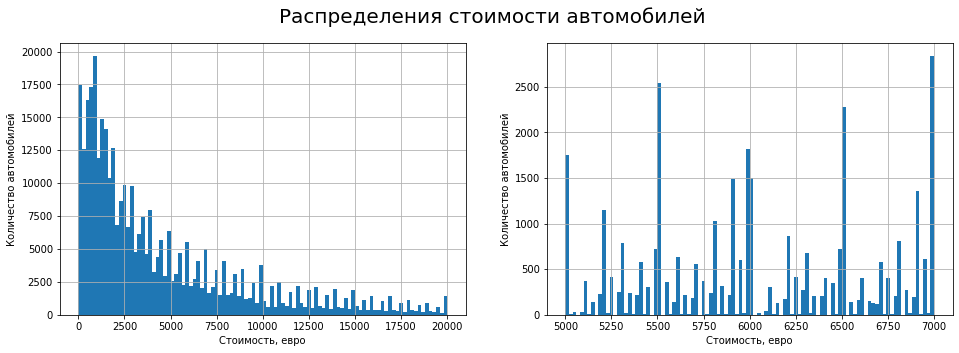

In [21]:
fig, axes = plt.subplots(1,2, figsize=(16,5))
fig.suptitle('Распределения стоимости автомобилей', fontsize=20)

ax1 = data['Price'].hist(bins=100, ax=axes[0])
ax1.set(xlabel='Стоимость, евро', ylabel = 'Количество автомобилей')

ax2 = data['Price'].hist(bins=100, range=(5000,7000))
ax2.set(xlabel='Стоимость, евро', ylabel = 'Количество автомобилей');

data['Price'].describe()

Стоимость автомобилей варьируется в диапазоне 0-20000 евро.

Видно, что цена может принимать любое целое значение. При этом владельцы часто устанавливают цену кратную 500 долларам, для примера график распределения цены в диапазоне 5000-7000 евро.

Также есть некоторое число автомобилей, стоимость которых равна 0.

In [22]:
print('Количество автомобилей, стоимость которых равна нулю:', data.query('Price == 0')['Price'].count())

Количество автомобилей, стоимость которых равна нулю: 10772


Возможно, владельцы указывают такие цены за автомобили, которые продаются "на запчасти"/отдаются просто так, так как не нужны.

Исходя из требований заказчика, необходимо построить модель, которая определяет стоимость автомобилей, а значит владельцу не понравится, если он увидит вместо цены 0. Удалим эти значения (около 3%), чтобы будующий пользователь смог увидеть более вдекватную оценку своего автомобиля. 

In [23]:
data = data.query('Price > 0')

**Мощность двигателя (л.с.)**

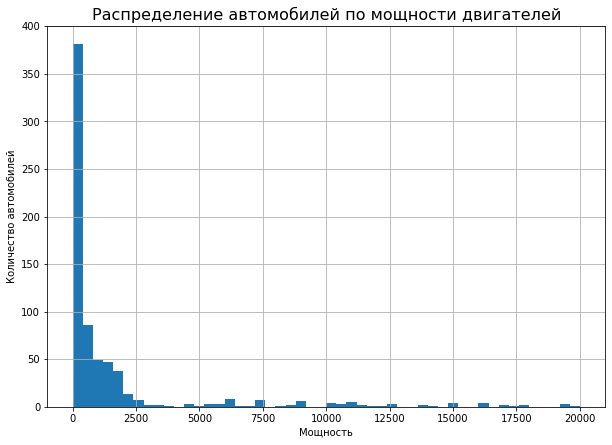

In [24]:
pd.Series(data['Power'].unique()).hist(figsize=(10,7), bins=50)
plt.xlabel('Мощность')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по мощности двигателей', fontsize=16);

Большинство автомобилей мощностью до 25000 л.с. Удалим автомобили с большей мощностью (99), так как таких мощностей не бывает, скорее всего пользователи добавили лишний ноль.

In [25]:
data = data.query('Power <= 2500')

**Пробег автомобиля (км)**

[5000,
 10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 125000,
 150000]

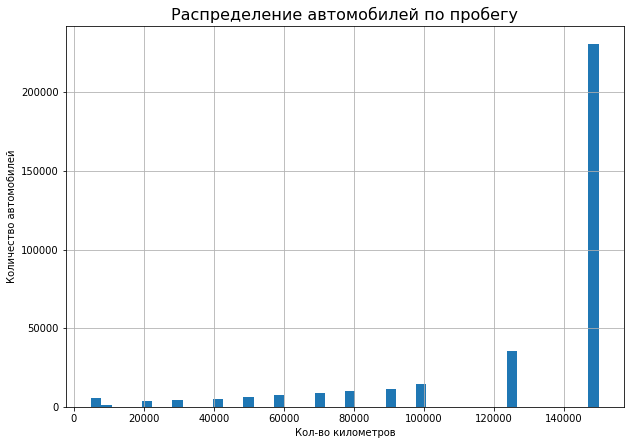

In [26]:
data['Kilometer'].hist(figsize=(10,7), bins=50)
plt.xlabel('Кол-во километров')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по пробегу', fontsize=16);

sorted(data['Kilometer'].unique())

Из графика можно увидеть, что эту переменную можно отнести к категориальным.

С данными все в порядке, выбросов не обнаружено. Продают в основном автомобили с большим пробегом (>= 100000), таких автомобилей ~82%.

**Количество фотографий автомобиля**

In [27]:
data['NumberOfPictures'].unique()

array([0])

В столбце NumberOfPictures все значения равны нулю. Удалим этот столбцец.

In [28]:
data = data.drop(['NumberOfPictures'], axis = 1)

**Дата создания анкеты**

Изменим тип данных с столбце DateCreated с object на datetime.

In [29]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')

print('Создание анкет:')
print('Начало:', data['DateCreated'].min())
print('Окончание:', data['DateCreated'].max())

Создание анкет:
Начало: 2014-03-10 00:00:00
Окончание: 2016-04-07 00:00:00


**Год регистрации автомобиля**

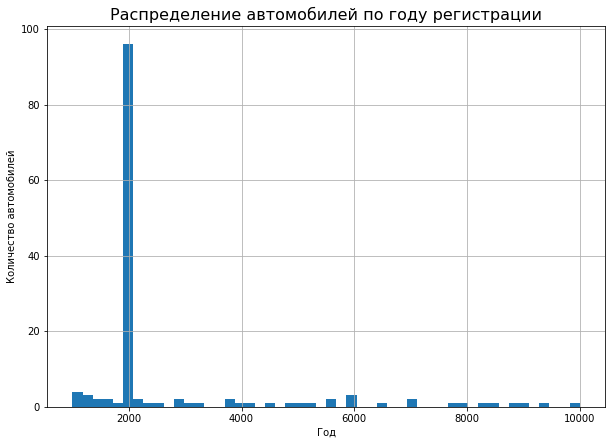

In [30]:
pd.Series(data['RegistrationYear'].unique()).hist(figsize=(10,7), bins=50)
plt.xlabel('Год')
plt.ylabel('Количество автомобилей')
plt.title('Распределение автомобилей по году регистрации', fontsize=16);

В данном столбце много выбросов. Удалим совсем старые автомомбили и объявления, где указан год регистрации автомобиля 2017 и позднее. Так как самое последнее объявление было размещено 7.04.2016 (data['DateCreated'].max()).

Ограничимся периодом - 1950 - 2016.

In [31]:
data = data.query('RegistrationYear > 1950 & RegistrationYear < 2017')

**Месяц регистрации автомобиля**

In [32]:
data.groupby('RegistrationMonth')['Price'].count()

RegistrationMonth
0     29365
1     21913
2     20123
3     32681
4     27652
5     27553
6     29757
7     25772
8     21359
9     22670
10    24797
11    22982
12    22909
Name: Price, dtype: int64

Заменим значение 0 в столбце RegistrationMonth на 1.

In [33]:
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

**Почтовый индекс владельца автомобиля**

Признак PostalCode не влияет на стоимость автомобиля - удалим данный столбец.

In [34]:
data = data.drop(['PostalCode'], axis = 1)

**Дата последней активности пользователя, дата скачивания анкеты из базы, дата создания анкеты**

Удаляем аналогично предыдущему пункту.

In [35]:
data = data.drop(['LastSeen', 'DateCrawled', 'DateCreated'], axis = 1)

Посмотрим на итоговую таблицу

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329533 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              329533 non-null  int64 
 1   VehicleType        329533 non-null  object
 2   RegistrationYear   329533 non-null  int64 
 3   Gearbox            329533 non-null  object
 4   Power              329533 non-null  int64 
 5   Model              329533 non-null  object
 6   Kilometer          329533 non-null  int64 
 7   RegistrationMonth  329533 non-null  int64 
 8   FuelType           329533 non-null  object
 9   Brand              329533 non-null  object
 10  Repaired           329533 non-null  object
dtypes: int64(5), object(6)
memory usage: 30.2+ MB


In [37]:
print('Кол-во удаленных объектов (в %) =', ((count_0 - data['Price'].count()) / count_0 * 100).round())

Кол-во удаленных объектов (в %) = 7.0


**Корреляционный анализ**

Посмотрим на матрицу корреляции между признаками. 

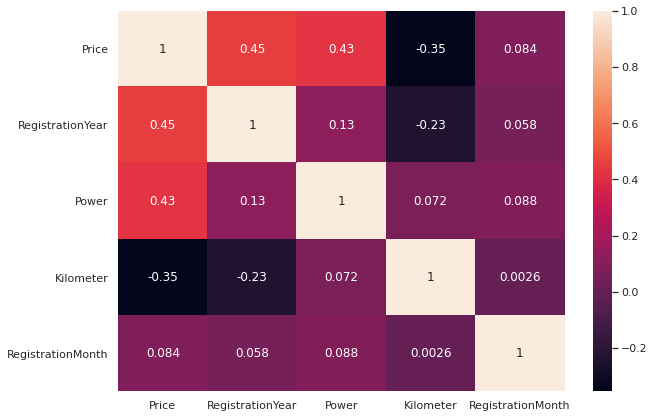

In [38]:
sns.set(rc={'figure.figsize':(10,7)})
sns.heatmap(data.corr(), annot = True, fmt='.2g');

Не было обнаружено ни сильной зависимости между признаками, ни сильной связи каждого признака с целевым столбцом.

Цена автомобиля сильно зависит от года регистрации автомобиля (0.45) и мощности (0.42). Чуть послабее зависит от пробега автомобиля (-0.34).
Все логично - чем новее, мощнее автомобиль, и чем меньше его пробег тем он дороже.

### Промежуточные выводы

На этапе предобработки данных:
- Были удалены явные дубликаты
- Заполнены пропуски в столбцах - VehicleType, Gearbox, FuelType, Model и Repaired. Пропуски в первых четырех столбцах были заполнены на основании того, какая модель/тип топлива и т.д. наиболее распространены у каждого бренда. Пропуски в последнем были заполнены новой категорией 'notspecify', так как не было обнаружено зависимости между этим признаком и остальными. 
- Удалены выбросы в столбцах - Power, RegistrationYear,  RegistrationMonth и Price.
- Удалены столбцы - NumberOfPictures, PostalCode, LastSeen, DateCrawled и DateCreated, как не несущие информацию для будущей модели.

Всего было удалено ~7% объектов.

## Построение моделей

Тестировать и выбирать лучшую модель будем из:
- RandomForestRegressor
- LinearRegression
- LightGBM
- CatBoost

Для оценки качества предсказаний будем использовать метрику RMSE.
Из требований заказчика известно, что ее значение не должно быть больше 2500.

Выбирать лучшую модель будем исходя из сравнения:
- качества предсказания
- времени обучения модели
- времени предсказания модели

### Кодирование и масштабирование признаков 

Для некоторых моделей необходимо преобразовать категориальные признаки в численные. Применим технику прямого кодирования - One-Hot Encoding для отдельных столбцов.

Разделим выборки на тренировочную(70%), валидационную(20%) и тестовую(10%).

In [39]:
features = data.drop(['Price'], axis=1)
target = data['Price']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target,
                                                                                        test_size=0.3,
                                                                                        random_state=RS)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,
                                                                            target_valid_test,
                                                                            test_size=0.33,
                                                                            random_state=RS)

In [40]:
print('Размер тренировочной выборки {:.0%}'.format(features_train.shape[0] / features.shape[0]))
print('Размер валидационной выборки {:.0%}'.format(features_valid.shape[0] / features.shape[0]))
print('Размер тестовой выборки {:.0%}'.format(features_test.shape[0] / features.shape[0]))

Размер тренировочной выборки 70%
Размер валидационной выборки 20%
Размер тестовой выборки 10%


Будем работать с тремя наборами данных. 

Первый, состоящий из количественных и категориальных переменных для алгоритмов LightGBMRegressor и CatBoostRegressor. 

Категориальные признаки во втором наборе (с добавкой _oe в названии) мы будем переводить в количественные для модели RandomForestRegressor, а с добавкой (_ohe), в третьем наборе, для модели LinearRegression.

Затем все наборы будем масштабировать

In [41]:
features_train_oe = features_train.copy()
features_valid_oe = features_valid.copy()
features_test_oe = features_test.copy()

target_train_oe = target_train.copy()
target_valid_oe = target_valid.copy()
target_test_oe = target_test.copy()



features_train_ohe = features_train.copy()
features_valid_ohe = features_valid.copy()
features_test_ohe = features_test.copy()

target_train_ohe = target_train.copy()
target_valid_ohe = target_valid.copy()
target_test_ohe = target_test.copy()

In [42]:
# Кодирование категориальных признаков (OrdinalEncoder)

columns_oe = ['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired']

encoder_oe = OrdinalEncoder()
encoder_oe.fit(features_train[columns_oe])

features_train_oe[columns_oe] = encoder_oe.transform(features_train_oe[columns_oe]) 
features_valid_oe[columns_oe] = encoder_oe.transform(features_valid_oe[columns_oe])
features_test_oe[columns_oe] = encoder_oe.transform(features_test_oe[columns_oe])



# Кодирование категориальных признаков (OneHotEncoder)

columns_ohe = columns_oe
encoder_ohe = OneHotEncoder()
encoder_ohe.fit(features_train_ohe[columns_ohe])

features_ohe_train = pd.DataFrame(encoder_ohe.transform(features_train_ohe[columns_ohe]).toarray(),
                                  index=features_train_ohe.index)
features_ohe_valid = pd.DataFrame(encoder_ohe.transform(features_valid_ohe[columns_ohe]).toarray(),
                                  index=features_valid_ohe.index)

features_ohe_train.columns = encoder_ohe.get_feature_names(columns_ohe)
features_ohe_valid.columns = encoder_ohe.get_feature_names(columns_ohe)

features_train_ohe = pd.concat([features_train_ohe, features_ohe_train], axis=1)
features_valid_ohe = pd.concat([features_valid_ohe, features_ohe_valid], axis=1)

features_train_ohe = features_train_ohe.drop(columns_ohe, axis=1)
features_valid_ohe = features_valid_ohe.drop(columns_ohe, axis=1)

Посмотрим на данные после кодирования

In [43]:
print('Оригинальный датасет')
display(features_train.head())

print('Датасет после OE-кодирования')
display(features_train_oe.head())

print('Датасет после OНE-кодирования')
display(features_train_ohe.head())

Оригинальный датасет


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
244185,suv,2006,auto,272,m_klasse,150000,10,petrol,mercedes_benz,no
141794,wagon,2002,manual,131,mondeo,150000,11,petrol,ford,no
273962,sedan,1998,manual,143,5er,150000,1,petrol,bmw,notspecify
296552,small,1996,manual,40,twingo,150000,7,petrol,renault,no
278030,sedan,2014,auto,105,golf,20000,3,petrol,volkswagen,no


Датасет после OE-кодирования


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
244185,6.0,2006,0.0,272,145.0,12.0,10,5.0,20.0,0.0
141794,7.0,2002,1.0,131,154.0,12.0,11,5.0,10.0,0.0
273962,4.0,1998,1.0,143,15.0,12.0,1,5.0,2.0,1.0
296552,5.0,1996,1.0,40,227.0,12.0,7,5.0,27.0,0.0
278030,4.0,2014,0.0,105,116.0,2.0,3,5.0,38.0,0.0


Датасет после OНE-кодирования


,RegistrationYear,Power,RegistrationMonth,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no,Repaired_notspecify,Repaired_yes
244185,2006,272,10,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
141794,2002,131,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
273962,1998,143,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
296552,1996,40,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
278030,2014,105,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Выполним масштабирование количественных признаков. При этом будем выполнять масштабирование дважды - сначала для первого набора. Там будем изменять только количественные признаки.

Для второго набора будем масштабировать все признаки, чтобы одни из них не стали для модели болле ценными, чем другие.

In [44]:
# Масштабирование данных первого набора
numeric = ['RegistrationYear', 'Power', 'RegistrationMonth']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])



# Масштабирование данных для второго набора
numeric = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
           'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

scaler = StandardScaler()
scaler.fit(features_train_oe[numeric])

features_train_oe = features_train_oe.copy()
features_valid_oe = features_valid_oe.copy()
features_test_oe = features_test_oe.copy()

features_train_oe[numeric] = scaler.transform(features_train_oe[numeric])
features_valid_oe[numeric] = scaler.transform(features_valid_oe[numeric])
features_test_oe[numeric] = scaler.transform(features_test_oe[numeric])



# Масштабирование данных для третьего набора
numeric = ['RegistrationYear', 'Power', 'RegistrationMonth']

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

features_train_ohe = features_train_ohe.copy()
features_valid_ohe = features_valid_ohe.copy()
features_test_ohe = features_test_ohe.copy()

features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [45]:
# Посмотрим на данные после масштабирования

display(features_train.head())
display(features_train_oe.head())
display(features_train_ohe.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
244185,suv,0.501013,auto,2.285511,m_klasse,150000,1.153130,petrol,mercedes_benz,no
141794,wagon,-0.091268,manual,0.304206,mondeo,150000,1.435124,petrol,ford,no
273962,sedan,-0.683550,manual,0.472828,5er,150000,-1.384819,petrol,bmw,notspecify
296552,small,-0.979690,manual,-0.974509,twingo,150000,0.307147,petrol,renault,no
278030,sedan,1.685576,auto,-0.061141,golf,20000,-0.820830,petrol,volkswagen,no


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
244185,0.827163,0.501013,-2.015207,2.285511,0.503521,0.503240,1.153130,0.12723,-0.059977,-0.578046
141794,1.313632,-0.091268,0.496227,0.304206,0.629991,0.503240,1.435124,0.12723,-0.811539,-0.578046
273962,-0.145774,-0.683550,0.496227,0.472828,-1.323262,0.503240,-1.384819,0.12723,-1.412788,0.936883
296552,0.340695,-0.979690,0.496227,-0.974509,1.655799,0.503240,0.307147,0.12723,0.466116,-0.578046
278030,-0.145774,1.685576,-2.015207,-0.061141,0.096008,-3.234989,-0.820830,0.12723,1.292835,-0.578046


,RegistrationYear,Power,RegistrationMonth,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no,Repaired_notspecify,Repaired_yes
244185,0.501013,2.285511,1.153130,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
141794,-0.091268,0.304206,1.435124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
273962,-0.683550,0.472828,-1.384819,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
296552,-0.979690,-0.974509,0.307147,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
278030,1.685576,-0.061141,-0.820830,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### RandomForestRegressor

Найдем лучшую модель RandomForestRegressor

est = 600 depth = 5 RMSE = 2410.4319080552627
est = 600 depth = 6 RMSE = 2270.351556331555
est = 600 depth = 7 RMSE = 2167.7068478692217
est = 600 depth = 8 RMSE = 2080.393935696901
est = 600 depth = 9 RMSE = 2001.3476053508261
est = 600 depth = 10 RMSE = 1925.5039390167226
est = 700 depth = 5 RMSE = 2410.5903010788984
est = 700 depth = 6 RMSE = 2270.3076551861595
est = 700 depth = 7 RMSE = 2167.6134002796935
est = 700 depth = 8 RMSE = 2080.228610509992
est = 700 depth = 9 RMSE = 2001.2528801497306
est = 700 depth = 10 RMSE = 1925.3663764573869
RMSE = 1925.3663764573869
depth = 10
est = 700


,est,depth,rmse_RFR
0,600.0,5.0,2410.431908
1,600.0,6.0,2270.351556
2,600.0,7.0,2167.706848
3,600.0,8.0,2080.393936
4,600.0,9.0,2001.347605
5,600.0,10.0,1925.503939
6,700.0,5.0,2410.590301
7,700.0,6.0,2270.307655
8,700.0,7.0,2167.613400
9,700.0,8.0,2080.228611


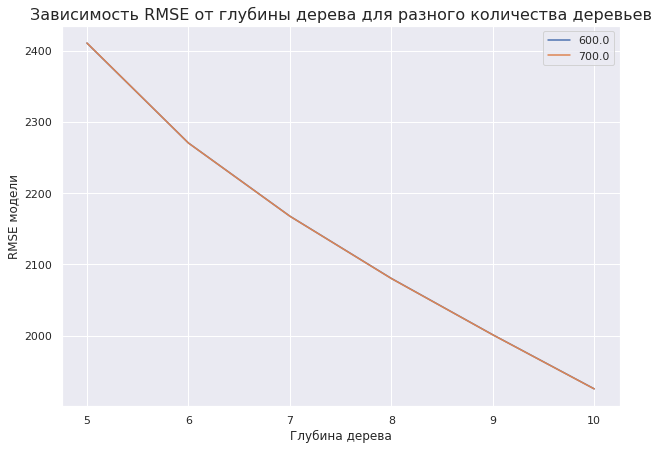

In [46]:
best_rmse_RFR = 5000
best_model_RFR = None
best_depth_RFR = 0
best_est_RFR = 0

tab_graph_RFR = pd.DataFrame(columns=['est', 'depth', 'rmse_RFR'])

for est in range(600, 800, 100):
    for depth in range(5,11):
        model_RFR = RandomForestRegressor(random_state=RS, n_estimators=est, max_depth=depth)
        model_RFR.fit(features_train_oe, target_train_oe)
        predict_RFR = model_RFR.predict(features_valid_oe)
        rmse_RFR = sqrt(mean_squared_error(target_valid_oe, predict_RFR))
        print('est =', est, 'depth =', depth, 'RMSE =', rmse_RFR)
        tab_graph_RFR = tab_graph_RFR.append({'est':est, 'depth':depth, 'rmse_RFR':rmse_RFR}, ignore_index=True)
        if rmse_RFR < best_rmse_RFR:
            best_model_RFR = model_RFR
            best_depth_RFR = depth
            best_est_RFR = est
            best_rmse_RFR = rmse_RFR
            
print('RMSE =', best_rmse_RFR)
print('depth =', best_depth_RFR)
print('est =', best_est_RFR)

display(tab_graph_RFR)
tab_graph_RFR.set_index('depth', inplace=True)
tab_graph_RFR.groupby('est')['rmse_RFR'].plot(figsize=(10,7), legend=True)
plt.xlabel('Глубина дерева')
plt.ylabel('RMSE модели')
plt.title('Зависимость RMSE от глубины дерева для разного количества деревьев', fontsize=16);

Замерим время обучения и время предсказания для лучшей модели на валидационной выборке.

In [47]:
start_train = time.time()
best_model_RFR.fit(features_train_oe, target_train_oe)
finish_train = time.time()
time_train_RFR = round(finish_train - start_train, 2)

start_valid = time.time()
predict_RFR = best_model_RFR.predict(features_valid_oe)
finish_valid = time.time()
time_valid_RFR = round(finish_valid - start_valid, 2)

print('RMSE =', rmse_RFR)
print('Время обучения =', time_train_RFR, 'с')
print('Время предсказания =', time_valid_RFR, 'с')

RMSE = 1925.3663764573869
Время обучения = 232.49 с
Время предсказания = 4.1 с


Построим гистрограмму распределения предсказанных и истинных значений цены автомобиля для модели RandomForestRegressor.

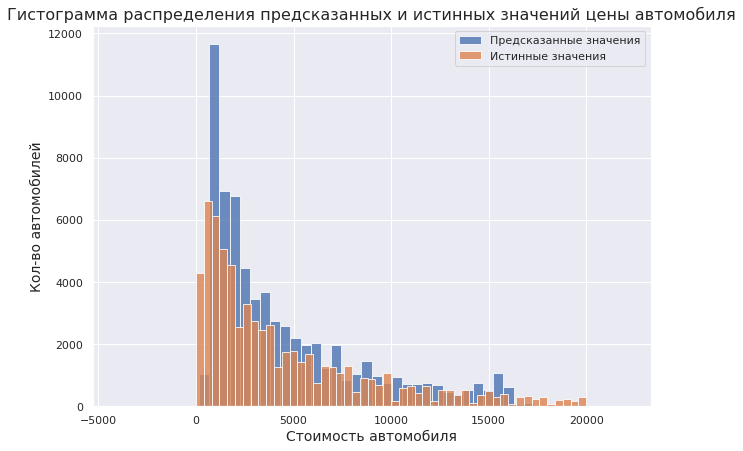

In [48]:
plt.figure(figsize=(10,7))
plt.hist(predict_RFR, bins=50, label='Предсказанные значения', alpha=0.8, range=(-4000, 22000))
plt.hist(target_valid_oe, bins=50, label='Истинные значения', alpha=0.8)
plt.title('Гистограмма распределения предсказанных и истинных значений цены автомобиля', fontsize=16)
plt.xlabel('Стоимость автомобиля', fontsize=14)
plt.ylabel('Кол-во автомобилей', fontsize=14)
plt.legend();

### LinearRegression

In [49]:
model_LR = LinearRegression()
start_train = time.time()
model_LR.fit(features_train_ohe, target_train_ohe)
finish_train = time.time()
time_train_LR = round(finish_train - start_train, 2)

start_valid = time.time()
predict_LR = model_LR.predict(features_valid_ohe)
finish_valid = time.time()
time_valid_LR = round(finish_valid - start_valid, 2)

rmse_LR = sqrt(mean_squared_error(target_valid_ohe, predict_LR))

print('RMSE =', rmse_LR)
print('Время обучения =', time_train_LR, 'с')
print('Время предсказания =', time_valid_LR, 'с')

RMSE = 2768.8725656361185
Время обучения = 54.15 с
Время предсказания = 0.23 с


Построим гистрограмму распределения предсказанных и истинных значений цены автомобиля для модели LinearRegression.

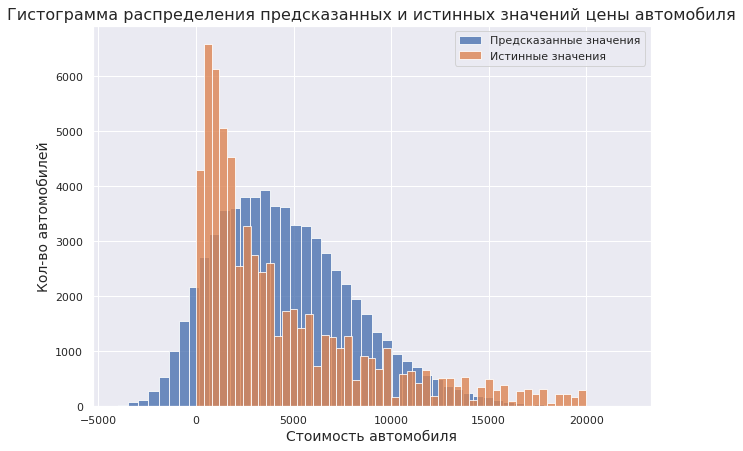

In [50]:
plt.figure(figsize=(10,7))
plt.hist(predict_LR, bins=50, label='Предсказанные значения', alpha=0.8, range=(-4000, 22000))
plt.hist(target_valid_oe, bins=50, label='Истинные значения', alpha=0.8)
plt.title('Гистограмма распределения предсказанных и истинных значений цены автомобиля', fontsize=16)
plt.xlabel('Стоимость автомобиля', fontsize=14)
plt.ylabel('Кол-во автомобилей', fontsize=14)
plt.legend();

### LightGBMRegressor

Изменим тип переменных на категориальный

In [51]:
features_train_LGBM = features_train.copy()
features_valid_LGBM = features_valid.copy()
features_test_LGBM = features_test.copy()

categorical_feature = ['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired']
for i in categorical_feature:
    features_train_LGBM[i] = features_train_LGBM[i].astype('category')
    features_valid_LGBM[i] = features_valid_LGBM[i].astype('category')
    features_test_LGBM[i] = features_test_LGBM[i].astype('category')

Сначала найдем параметры, при которых у модели будет наименьшее RMSE

[100]	valid_0's rmse: 1643.08
[200]	valid_0's rmse: 1622.43
[300]	valid_0's rmse: 1609.77
[400]	valid_0's rmse: 1602.91
[500]	valid_0's rmse: 1598.74
[600]	valid_0's rmse: 1596.97
[700]	valid_0's rmse: 1597.5
[800]	valid_0's rmse: 1596.6
[900]	valid_0's rmse: 1597.05
[1000]	valid_0's rmse: 1597.12
[1100]	valid_0's rmse: 1597.27
[1200]	valid_0's rmse: 1598.41


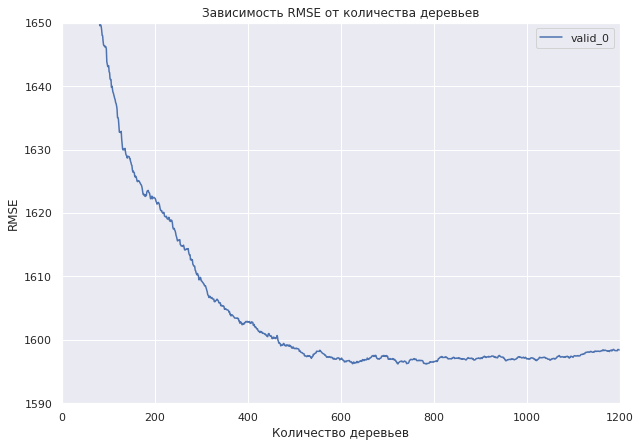

In [52]:
model_LGBM = LGBMRegressor(n_estimators=1200, random_state=123, learning_rate=0.4, metric='rmse')
model_LGBM.fit(features_train_LGBM, target_train, eval_set=(features_valid_LGBM, target_valid), verbose=100,
               categorical_feature=['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired'])

lgbm.plot_metric(model_LGBM,
                 metric='rmse',
                 figsize=(10,7),
                 ylim=(1590,1650),
                 title='Зависимость RMSE от количества деревьев',
                 xlabel='Количество деревьев',
                 ylabel='RMSE');

Еще раз обучим модель на наилучших параметрах: n_estimators = 800, чтобы отдельно замерить время обучения и предсказания.

In [53]:
start_train = time.time()
model_LGBM = LGBMRegressor(n_estimators=800, random_state=123, learning_rate=0.4, metric='rmse')
model_LGBM.fit(features_train_LGBM, target_train, eval_set=(features_valid_LGBM, target_valid), verbose=100,
               categorical_feature=['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired'])
finish_train = time.time()
time_train_LGBM = round(finish_train - start_train, 2)

start_valid = time.time()
predict_LGBM = model_LGBM.predict(features_valid_LGBM)
finish_valid = time.time()
time_valid_LGBM = round(finish_valid - start_valid, 2)

rmse_LGBM = sqrt(mean_squared_error(target_valid, predict_LGBM))

print('RMSE =', rmse_LGBM)
print('Время обучения =', time_train_LGBM, 'с')
print('Время предсказания =', time_valid_LGBM, 'с')

[100]	valid_0's rmse: 1643.08
[200]	valid_0's rmse: 1622.43
[300]	valid_0's rmse: 1609.77
[400]	valid_0's rmse: 1602.91
[500]	valid_0's rmse: 1598.74
[600]	valid_0's rmse: 1596.97
[700]	valid_0's rmse: 1597.5
[800]	valid_0's rmse: 1596.6
RMSE = 1596.5986116029658
Время обучения = 2426.97 с
Время предсказания = 2.22 с


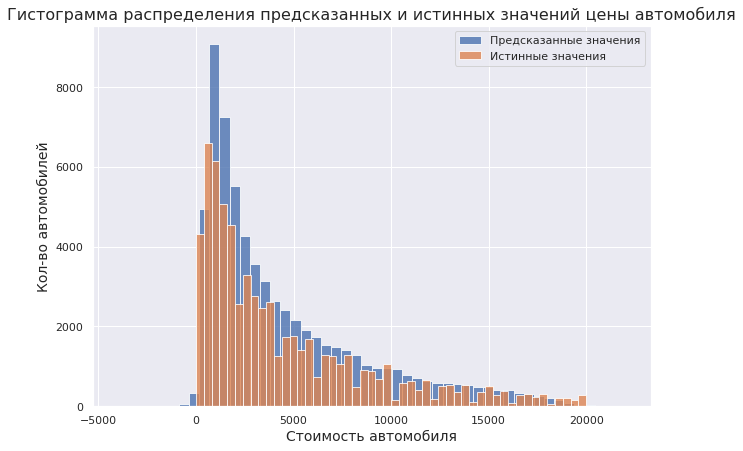

In [54]:
plt.figure(figsize=(10,7))
plt.hist(predict_LGBM, bins=50, label='Предсказанные значения', alpha=0.8, range=(-4000, 22000))
plt.hist(target_valid, bins=50, label='Истинные значения', alpha=0.8)
plt.title('Гистограмма распределения предсказанных и истинных значений цены автомобиля', fontsize=16)
plt.xlabel('Стоимость автомобиля', fontsize=14)
plt.ylabel('Кол-во автомобилей', fontsize=14)
plt.legend();

### CatBoostRegressor

In [55]:
start_train = time.time()
model_CBR = CatBoostRegressor(random_state=RS, loss_function='RMSE', learning_rate=0.4, verbose=100, n_estimators=3000)
model_CBR.fit(features_train, target_train, eval_set=(features_valid, target_valid),
              cat_features=['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired'], plot=True)
finish_train = time.time()
time_train_CBR = round(finish_train - start_train, 2)

start_valid = time.time()
predict_CBR = model_CBR.predict(features_valid)
finish_valid = time.time()
time_valid_CBR = round(finish_valid - start_valid, 2)

rmse_CBR = sqrt(mean_squared_error(target_valid, predict_CBR))

print('RMSE =', rmse_CBR)
print('Время обучения =', time_train_CBR, 'с')
print('Время предсказания =', time_valid_CBR, 'с')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3470.3237544	test: 3464.7060916	best: 3464.7060916 (0)	total: 372ms	remaining: 18m 36s
100:	learn: 1682.5419486	test: 1713.2856349	best: 1713.2856349 (100)	total: 27s	remaining: 12m 55s
200:	learn: 1616.4682316	test: 1669.2407276	best: 1669.1782032 (199)	total: 54.5s	remaining: 12m 38s
300:	learn: 1580.5515060	test: 1652.3428426	best: 1652.3428426 (300)	total: 1m 20s	remaining: 12m 6s
400:	learn: 1554.0384690	test: 1641.4135469	best: 1641.4135469 (400)	total: 1m 47s	remaining: 11m 37s
500:	learn: 1528.7649192	test: 1632.9415241	best: 1632.9415241 (500)	total: 2m 14s	remaining: 11m 9s
600:	learn: 1510.0334615	test: 1626.4141001	best: 1626.2525089 (596)	total: 2m 41s	remaining: 10m 45s
700:	learn: 1492.5482309	test: 1621.2734627	best: 1621.2433665 (699)	total: 3m 9s	remaining: 10m 22s
800:	learn: 1478.5401705	test: 1618.0845632	best: 1618.0231007 (798)	total: 3m 38s	remaining: 9m 58s
900:	learn: 1466.1873994	test: 1616.9872756	best: 1616.9580412 (899)	total: 4m 5s	remaining: 9m

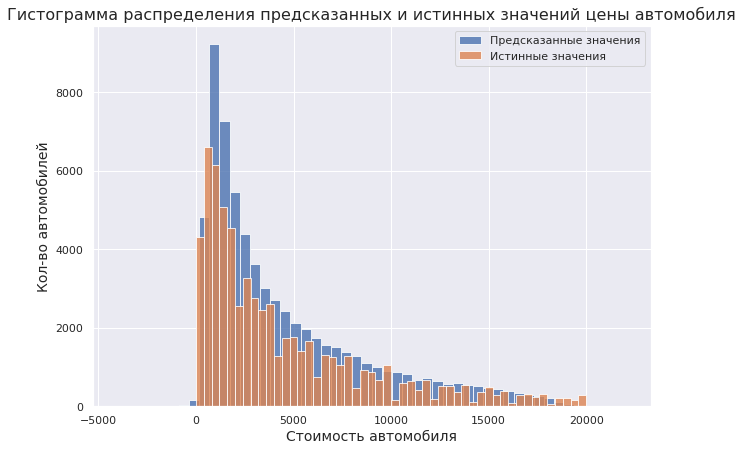

In [56]:
plt.figure(figsize=(10,7))
plt.hist(predict_CBR, bins=50, label='Предсказанные значения', alpha=0.8, range=(-4000, 22000))
plt.hist(target_valid, bins=50, label='Истинные значения', alpha=0.8)
plt.title('Гистограмма распределения предсказанных и истинных значений цены автомобиля', fontsize=16)
plt.xlabel('Стоимость автомобиля', fontsize=14)
plt.ylabel('Кол-во автомобилей', fontsize=14)
plt.legend();

## Анализ моделей

Сравним модели

In [57]:
column=['RMSE модели','Время обуч. модели, с', 'Время предск. модели, c']

result = pd.DataFrame(index=column,
                      columns=['RandomForestRegressor','LinearRegression',
                                        'LightGBMRegressor', 'CatBoostRegressor'])
result['RandomForestRegressor'] = rmse_RFR, time_train_RFR, time_valid_RFR
result['LinearRegression'] = rmse_LR, time_train_LR, time_valid_LR
result['LightGBMRegressor'] = rmse_LGBM, time_train_LGBM, time_valid_LGBM
result['CatBoostRegressor'] = rmse_CBR, time_train_CBR, time_valid_CBR

result

,RandomForestRegressor,LinearRegression,LightGBMRegressor,CatBoostRegressor
RMSE модели,1925.366376,2768.872566,1596.598612,1596.748072
"Время обуч. модели, с",232.490000,54.150000,2426.970000,860.540000
"Время предск. модели, c",4.100000,0.230000,2.220000,2.120000


По таблице можно увидеть, что RMSE LinearRegression больше 2500, а значит нам не подходят. RMSE RandomForestRegressor тоже великовато. 

Сравнивая базовые конфигурации LightGBMRegressor и CatBoostRegressor, по итоговому показателю RMSE они одинаковые. При этом, CatBoostRegressor почти в 4 раза быстрее обучается, а время предсказания у них практически одинаковое. Значит, выигрывает модель CatBoostRegressor.

Интересно протестировать обе модели - LightGBMRegressor и CatBoostRegressor.

## Тестирование моделей

Начнем с модели LightGBMRegressor.

In [58]:
predict_LGBM_test = model_LGBM.predict(features_test_LGBM)

rmse_LGBM_test = sqrt(mean_squared_error(target_test, predict_LGBM_test))
print('RMSE на тестовой выборке =', rmse_LGBM_test)

RMSE на тестовой выборке = 1620.2141675901469


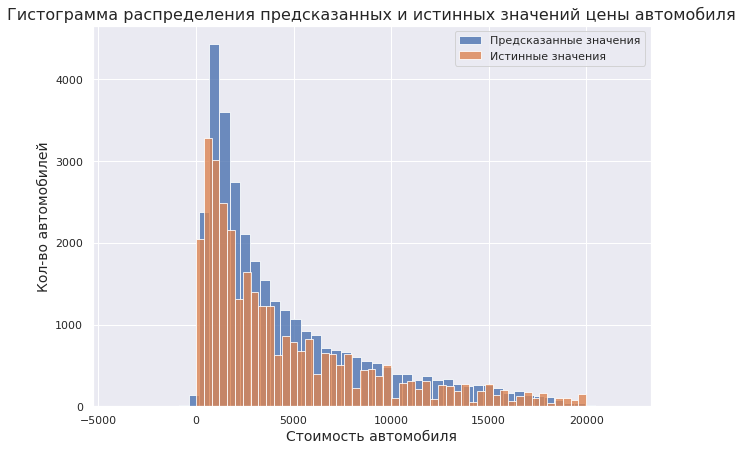

In [59]:
plt.figure(figsize=(10,7))
plt.hist(predict_LGBM_test, bins=50, label='Предсказанные значения', alpha=0.8, range=(-4000, 22000))
plt.hist(target_test, bins=50, label='Истинные значения', alpha=0.8)
plt.title('Гистограмма распределения предсказанных и истинных значений цены автомобиля', fontsize=16)
plt.xlabel('Стоимость автомобиля', fontsize=14)
plt.ylabel('Кол-во автомобилей', fontsize=14)
plt.legend();

Проведем анализ важности признаков

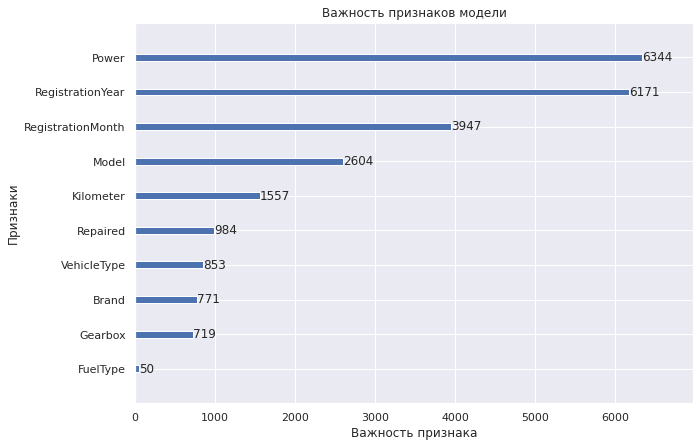

In [60]:
lgbm.plot_importance(model_LGBM,
                     figsize=(10,7),
                     title='Важность признаков модели',
                     xlabel='Важность признака',
                     ylabel='Признаки');

Самыми важными признаками являются - мощность двигателя, год и месяц регистрации автомобиля.  

Теперь займемся моделью CatBoostRegressor.

In [65]:
predict_CBR_test = model_CBR.predict(features_test)
rmse_CBR_test = sqrt(mean_squared_error(target_test, predict_CBR_test))
print('RMSE на тестовой выборке =', rmse_CBR_test)

RMSE на тестовой выборке = 1617.0707465178284


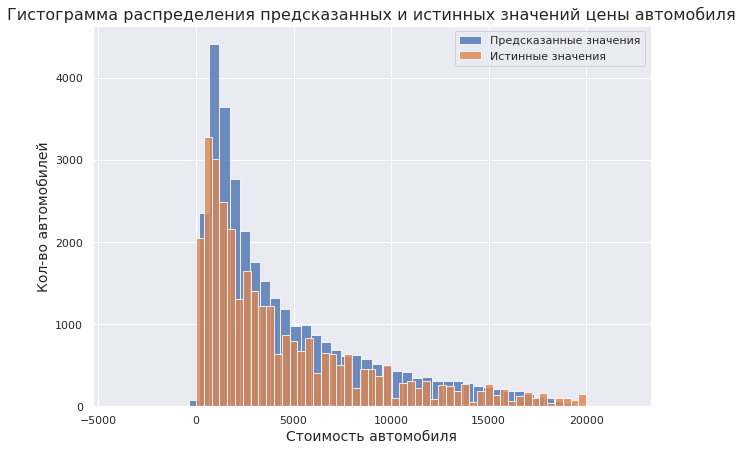

In [66]:
plt.figure(figsize=(10,7))
plt.hist(predict_CBR_test, bins=50, label='Предсказанные значения', alpha=0.8, range=(-4000, 22000))
plt.hist(target_test, bins=50, label='Истинные значения', alpha=0.8)
plt.title('Гистограмма распределения предсказанных и истинных значений цены автомобиля', fontsize=16)
plt.xlabel('Стоимость автомобиля', fontsize=14)
plt.ylabel('Кол-во автомобилей', fontsize=14)
plt.legend();

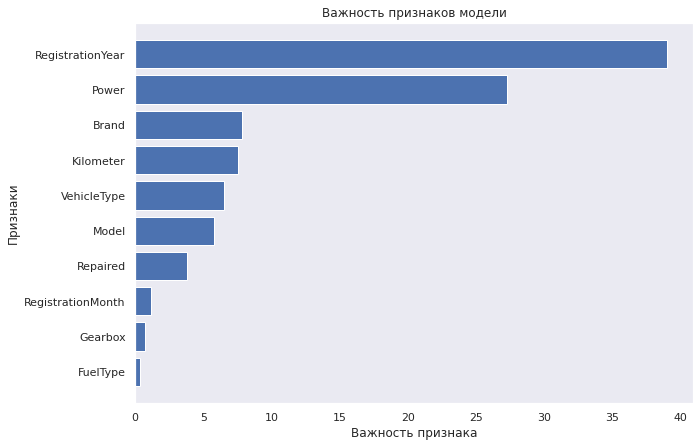

In [67]:
feature_importance = model_CBR.feature_importances_
feature_sorted = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 7))
plt.barh(range(len(feature_sorted)), feature_importance[feature_sorted], align='center')
plt.yticks(range(len(feature_sorted)), np.array(features_test.columns)[feature_sorted])
plt.title('Важность признаков модели')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.grid();

Здесь аналогично самыми важными являются год регистрации и мощность автомобиля. При этом на третьем месте расположена марка автомобиля. 

## Итоговый вывод по проекту

Перед нами стояла задача построения модели, которая будет определять рыночную стоимость автомобиля, исходя из его характеристик. 

Для этого данные были загружены, предобработаны и проанализированы - были удалены дубликаты и аномалии, заполнены пропуски. Неинформативные признаки также были удалены.

Заьем данные были поделены на тренировочный, валидационный и тестовый датасеты, закодированы и отмасштабированы. После были выбраны несколько моделей, которые сравнивались между собой по трем показателям:
- по времени обучения
- времени предсказания
- по метрике - RMSE

Строились следующие модели:
- LinearRegression
- RandomForestRegressorлях
- LightGBM
- CatBoostRegressor

Лучшей моделью была признана модель градиентного бустинга - CatBoostRegressor. Качество предсказаний на ней совпало с моделью LightGBM, но время обучения было сущетсвенно меньше.
Итоговый RMSE модели на тестовой выборке - 1617.